In [1]:
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import umap
import sklearn.decomposition
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import MDS
from scipy.sparse.csgraph import connected_components
import warnings
warnings.simplefilter('ignore')
import screcode
import vmapper
import mappertools.mapper.hierarchical_clustering
import datetime
import os
seed = 0

In [2]:
adata_all = scv.datasets.pancreas()
adata_all.layers['count'] = adata_all.X.toarray()

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:41) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


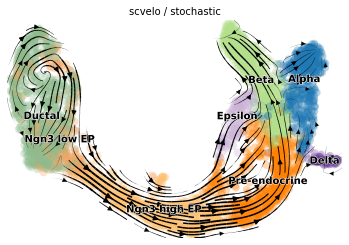

In [3]:
mode = 'stochastic' #'deterministic','stochastic','dynamical'
scv.pp.filter_and_normalize(adata_all)
scv.pp.log1p(adata_all)
scv.pp.moments(adata_all, n_pcs=None, n_neighbors=30)
if mode=='dynamical':
    scv.tl.recover_dynamics(adata_all)
scv.tl.velocity(adata_all,mode=mode)
scv.tl.velocity_graph(adata_all)
scv.pl.velocity_embedding_stream(adata_all,basis='umap',title='scvelo / %s' % mode)

In [4]:
## select data
slct_cell = np.array(['Alpha','Beta','Delta', 'Epsilon','Pre-endocrine'])
cell_types = np.array(adata_all.obs['clusters'].values)
idx_slct = np.empty(0,dtype=int)
for i in range(len(slct_cell)):
    idx_slct = np.append(idx_slct,np.where(cell_types==slct_cell[i])[0])
n_slct = len(idx_slct)
# adata = scv.datasets.pancreas()[idx_slct]
adata = adata_all[idx_slct].copy()
adata.shape

(1876, 27998)

In [5]:
## UMAP
n_neighbors = 15 # default:15
n_components = 2
d_dr = 30
data_pca = sklearn.decomposition.PCA(n_components=d_dr).fit_transform(adata.X.toarray())
adata.obsm['X_umap_endo'] = umap.UMAP(n_components=n_components,n_neighbors=n_neighbors,random_state=seed).fit_transform(data_pca)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_endo', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_png.png


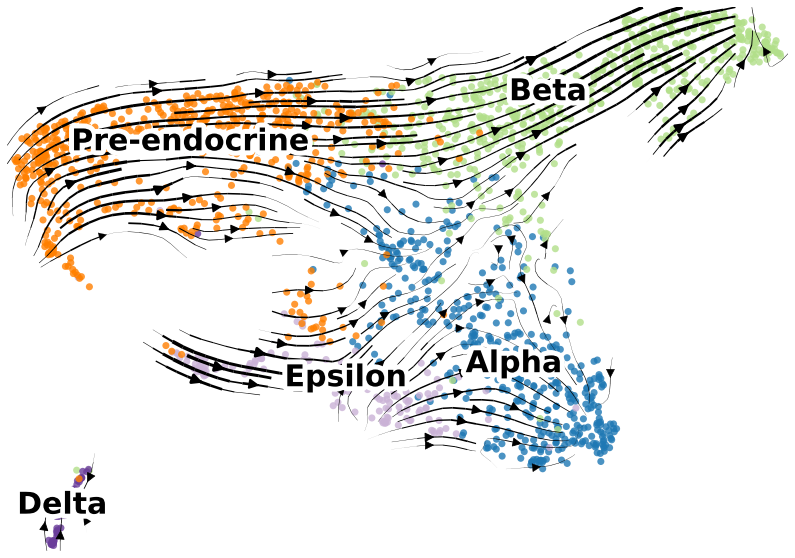

In [6]:
scv.pl.velocity_embedding_stream(adata,basis='umap_endo',title='',
                                 save='png',fontsize=0,legend_fontsize=30,figsize=(14,10),alpha=0.8,size=200,linewidth=2,arrow_size=2,arrow_color='k',legend_fontoutline=10)

start RECODE for scRNA-seq
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 10602, '#non-significant genes': 7148, '#silent genes': 10248, 'ell': 100, 'Elapsed time': '25.3455[sec]'}


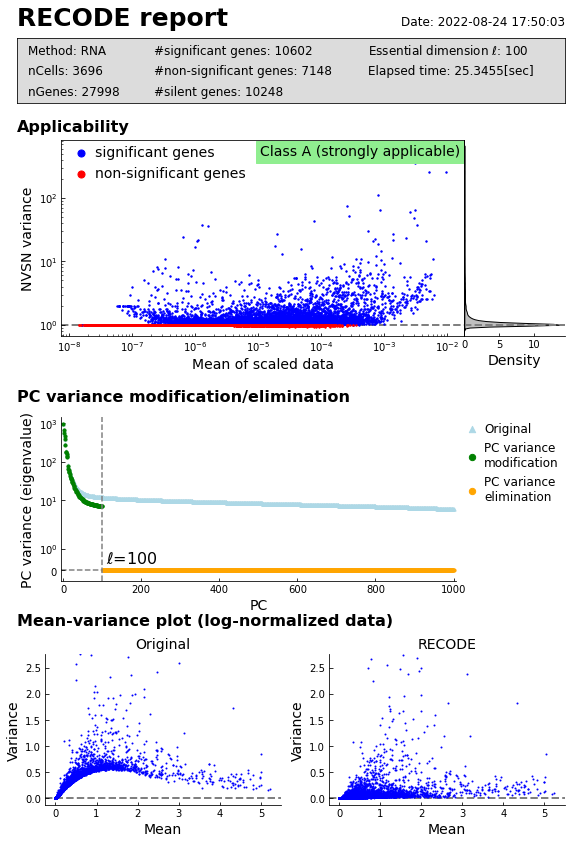

In [7]:
recode = screcode.RECODE()
adata_all.layers['RECODE'] = recode.fit_transform(adata_all.layers['count'])
recode.report()

In [8]:
## size scaling
adata.uns['size_factor'] = np.median(adata.obs['n_counts'])
adata.layers['X_ss'] = adata.uns['size_factor']*(adata.layers['count'].T/adata.obs['n_counts'].values).T
adata.layers['X_ss_log'] = np.log2(adata.layers['X_ss']+1)

adata.layers['RECODE'] = adata_all.layers['RECODE'][idx_slct]
adata.obs['n_counts_RECODE'] = np.sum(adata.layers['RECODE'],axis=1)
adata.uns['size_factor_RECODE'] = np.median(adata.obs['n_counts_RECODE'])
adata.layers['RECODE_ss'] = adata.uns['size_factor_RECODE']*(adata.layers['RECODE'].T/adata.obs['n_counts_RECODE'].values).T
adata.layers['RECODE_ss_log'] = np.log2(adata.layers['RECODE_ss']+1)

print(adata.uns['size_factor'],adata.uns['size_factor_RECODE'])

6194.0 5543.833039148389


In [9]:
## MDS (filter function)
d_mds = 3
n_init = 4  # default 4
adata.obsm['X_ss_log_MDS'] = MDS(n_components=d_mds,n_init=n_init,random_state=seed).fit_transform(adata.layers['X_ss_log'])
adata.obsm['RECODE_ss_log_MDS'] = MDS(n_components=d_mds,n_init=n_init,random_state=seed).fit_transform(adata.layers['RECODE_ss_log'])

In [10]:
# output directory
dt_now = datetime.datetime.now()
out_dir = 'output/Endocrine/%s%02d%02d' % (dt_now.year,dt_now.month,dt_now.day)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

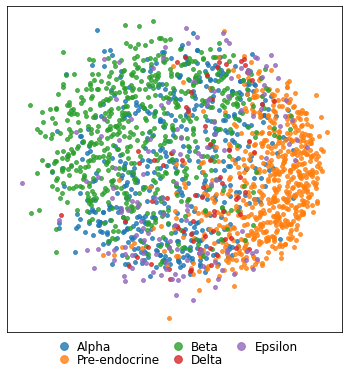

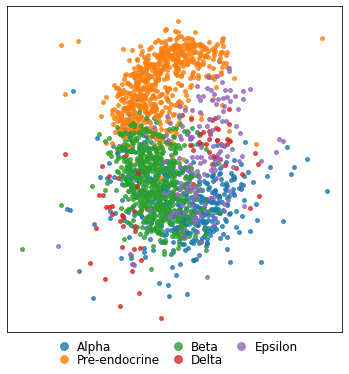

In [11]:
## plot MDS
import matplotlib
clusters = adata.obs['clusters'].values
cluster_names = ['Alpha','Pre-endocrine','Beta','Delta','Epsilon']

def plot_2d(plt_data,clusters,savefigname):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    for i_clstr in cluster_names:
        idx = clusters == i_clstr
        ax.scatter(plt_data[idx,0],plt_data[idx,1],s=15,label=i_clstr,alpha=0.8)
    ax.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=3,fontsize=12,markerscale=2, frameon=False,
             borderpad=0.1,labelspacing=0.0,columnspacing=0.5,handletextpad=0.1)
    plt.savefig('%s/%s.png' % (out_dir,savefigname),bbox_inches = 'tight',dpi=200)
    
plot_2d(adata.obsm['X_ss_log_MDS'],clusters,'MDS2D_Raw')
plot_2d(adata.obsm['RECODE_ss_log_MDS'],clusters,'MDS2D_RECODE')

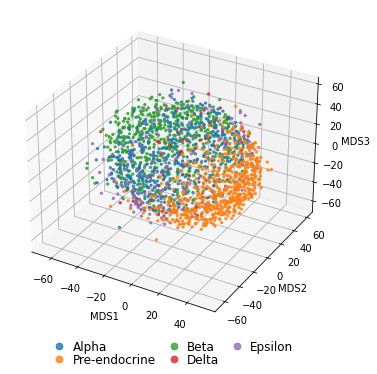

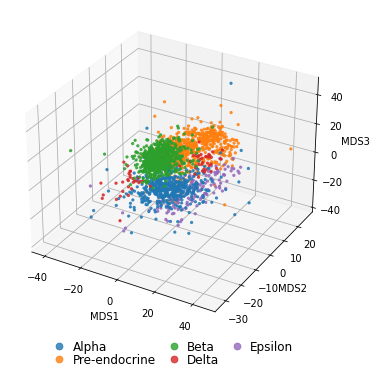

In [12]:
## plot MDS
clusters = adata.obs['clusters'].values
cluster_names = ['Alpha','Pre-endocrine','Beta','Delta','Epsilon']

def plot_3d(plt_data,clusters,savefigname):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1, projection='3d')
    for i_clstr in cluster_names:
        idx = clusters ==i_clstr
        ax.scatter(plt_data[idx,0],plt_data[idx,1],plt_data[idx,2],s=5,label=i_clstr,alpha=0.8)
    # ax.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)
    ax.set_xlabel('MDS1')
    ax.set_ylabel('MDS2')
    ax.set_zlabel('MDS3')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.0), ncol=3,fontsize=12,markerscale=3, frameon=False,
             borderpad=0.1,labelspacing=0.0,columnspacing=0.5,handletextpad=0.1)
    plt.savefig('%s/%s.png' % (out_dir,savefigname),bbox_inches = 'tight',dpi=200)
    
plot_3d(adata.obsm['X_ss_log_MDS'],clusters,'MDS3D_Raw')
plot_3d(adata.obsm['RECODE_ss_log_MDS'],clusters,'MDS3D_RECODE')

In [ ]:
## Mapper data
clusterer = mappertools.mapper.hierarchical_clustering.HeuristicHierarchical(verbose=0,metric='Euclidean',heuristic='firstgap')
##make cluster
clstr = np.array(adata.obs['clusters_coarse'].values)
clstr_temp = np.array(adata.obs['clusters'].values)
for i in range(len(clstr)):
    if clstr[i] != clstr_temp[i]:
        clstr[i] += '(%s)' % (clstr_temp[i])
#
n,d = adata.shape
meta_data = np.empty([n+1,5],dtype=object)
meta_data[0,0] = ''
meta_data[1:,0] = np.arange(n)+1
meta_data[0,1] = 'clstr'
meta_data[1:,1] = clstr
meta_data[0,2] = 'clstr_coarse'
meta_data[1:,2] = adata.obs['clusters_coarse'].values
meta_data[0,3] = 'G2M_score'
meta_data[1:,3] = adata.obs['G2M_score'].values
meta_data[0,4] = 'S_score'
meta_data[1:,4] = adata.obs['S_score'].values
meta_func = np.array([['clstr','clstr','clstr','clstr_coarse','clstr_coarse','clstr_coarse','S_score','G2M_score'],
                      ['set','list-percent','dominant','set','list-percent','dominant','mean','mean']])

gene_list = np.sort(['Neurog2','Neurog3','Mafb','Meis2','Slc38a5','Arx','Fev','Sct','Sult2b1','Upk3bl','Gng13','Gm8773','Steap1'])
data_gene = adata.layers['RECODE_ss_log']
for gene in gene_list:
    if sum(adata.var.index == gene)>0:
        idx = adata.var.index == gene
        meta_data = np.hstack((meta_data,np.vstack((np.array(gene)[np.newaxis,np.newaxis],data_gene[:,idx]))))
        meta_func = np.hstack((meta_func,[[gene],['mean']]))
    else:
        print('Not found %s' % gene)

import pandas as pd
pd.DataFrame(meta_data[1:,1:],columns=meta_data[0,1:],index=meta_data[1:,0])

Clustering using: Hierarchical clustering with single linkage and firstgap heuristic.


,clstr,clstr_coarse,G2M_score,S_score,Arx,Fev,Gm8773,Gng13,Mafb,Meis2,Neurog2,Neurog3,Sct,Slc38a5,Steap1,Sult2b1,Upk3bl
1,Endocrine(Alpha),Endocrine,-0.286834,-0.171255,1.7780265662952128,2.8483560253825515,0.09829307478842404,0.08369533660777359,1.5410226289396438,2.1997299112288524,0.0,0.0,1.4137064422480825,0.0,0.11689341202662874,0.0,0.0
2,Endocrine(Alpha),Endocrine,-0.179372,-0.172579,1.545752709890007,0.0,0.0,0.03260483217338193,2.177578279863573,3.0756395286368394,0.0,1.0196674724984305,1.1108561176931508,5.203755662290662,0.0,0.07104211721300004,0.12267735530896408
3,Endocrine(Alpha),Endocrine,-0.260845,-0.230815,1.8069127182597458,1.7711745005642683,0.0,0.03240438684373027,2.193852944300762,2.9454487204959734,0.0,0.6687514568575003,1.2371677354276172,4.185344014958476,0.11321292373832945,0.0,0.0
4,Endocrine(Alpha),Endocrine,-0.362891,-0.211025,1.5044378748118545,2.846668083879133,0.024216584929209684,0.014140991204581682,1.4308201736379922,2.2676302062340623,0.0,1.7954173020678037,1.0141498818604395,2.2246213018289405,0.18947248192679061,0.15194382470914208,0.0
5,Endocrine(Alpha),Endocrine,-0.286424,-0.331027,1.9545735742642842,1.627830242865259,0.11781397430671192,0.05023379139758567,1.68031611437886,2.822862903411847,0.0,0.0,0.9212455811930507,1.905132105251973,0.15010262436730998,0.1934906628486703,0.17156591213790445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,Pre-endocrine,Pre-endocrine,-0.244563,-0.253758,0.28119489504172296,3.721955372303928,0.0,0.018431542939998952,0.7292617162136323,0.0,0.0,3.6436512246455006,0.32908012445963297,4.007901446261499,0.15481576447037368,0.9188761518533601,0.4754673475958451
1873,Pre-endocrine,Pre-endocrine,-0.237752,-0.106154,0.0,3.312234409812668,0.0,0.032206135374201486,2.3939493813444503,1.8834915976977247,0.0,0.0,0.31042426818566665,1.442199176088753,0.12396209857471038,0.2536849229083533,0.061190819536119975
1874,Pre-endocrine,Pre-endocrine,-0.259989,-0.232021,0.0,3.634228071777765,0.004768819190029077,0.058989338538627346,1.9906548687959975,1.1386972787126706,0.0,3.1268864384791444,0.23242159478966087,4.194751885678861,0.17651675466830166,0.5808795654026221,0.038236784409208247
1875,Pre-endocrine,Pre-endocrine,-0.254821,-0.298142,0.0,3.2313534155586074,0.0,0.020983551684373356,2.5450634705346955,1.589341576475916,0.0,1.963502268188397,0.3030562632884043,4.271510557371684,0.11658145377752707,0.133805904819724,0.03200520035848069


In [20]:
## V-Mapper
num_cubes = [21,22,23,24,25] # 
adaptive = True
mode_list = ['stochastic']


data_mapper = adata.layers['X_ss_log']
data_mapper_p = adata.obsm['X_ss_log_MDS']
for num_cube in num_cubes:
    t = datetime.datetime.now()
    print('start (n_cubes=%d): %02d:%02d:%02d' % (num_cube,t.hour,t.minute,t.second))
    mapper = vmapper.mapper(
        data=data_mapper,
        data_p=data_mapper_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    for mode in mode_list:
        file_name = 'vmapper_Endocrine_raw_MDS%d_n%02d' % (d_mds,num_cube)
        data_vel = adata.layers['velocity']
        if adaptive:
            file_name += '_adv'
        file_name += '_' + mode
        mapper.out_cytoscape_V(
            data = data_mapper,
            data_vel = data_vel,
            sample_name = np.arange(n)+1,
            meta_data = meta_data,
            meta_func = meta_func,
            out_dir=out_dir,
            out_file=file_name,
            fig_title=file_name,
        )
    t = datetime.datetime.now()
    print('end   (n_cubes=%d): %02d:%02d:%02d' % (num_cube,t.hour,t.minute,t.second))

data_mapper = adata.layers['RECODE_ss_log']
data_mapper_p = adata.obsm['RECODE_ss_log_MDS']
for num_cube in num_cubes:
    t = datetime.datetime.now()
    print('start (n_cubes=%d): %02d:%02d:%02d' % (num_cube,t.hour,t.minute,t.second))
    mapper = vmapper.mapper(
        data=data_mapper,
        data_p=data_mapper_p,
        num_cube=num_cube,
        overlap=0.5,
        clusterer=clusterer,
        adaptive=adaptive
    )
    for mode in mode_list:
        file_name = 'vmapper_Endocrine_RECODE_MDS%d_n%02d' % (d_mds,num_cube)
        data_vel = adata.layers['velocity']
        if adaptive:
            file_name += '_adv'
        file_name += '_' + mode
        mapper.out_cytoscape_V(
            data = data_mapper,
            data_vel = data_vel,
            sample_name = np.arange(n)+1,
            meta_data = meta_data,
            meta_func = meta_func,
            out_dir=out_dir,
            out_file=file_name,
            fig_title=file_name,
        )
    t = datetime.datetime.now()
    print('end   (n_cubes=%d): %02d:%02d:%02d' % (num_cube,t.hour,t.minute,t.second))

start (n_cubes=21): 16:47:50
end   (n_cubes=21): 17:12:53
start (n_cubes=22): 17:12:53
end   (n_cubes=22): 17:38:03
start (n_cubes=23): 17:38:03
end   (n_cubes=23): 18:01:11
start (n_cubes=24): 18:01:11
end   (n_cubes=24): 18:24:51
start (n_cubes=25): 18:24:51
end   (n_cubes=25): 18:48:06
start (n_cubes=21): 18:48:06
end   (n_cubes=21): 19:08:50
start (n_cubes=22): 19:08:50
end   (n_cubes=22): 19:30:21
start (n_cubes=23): 19:30:21
end   (n_cubes=23): 19:51:20
start (n_cubes=24): 19:51:20
end   (n_cubes=24): 20:14:27
start (n_cubes=25): 20:14:27
end   (n_cubes=25): 20:35:42
